# Normalisation

La normalisation des données est souvent inutile d'un point de vue mathématique. C'est une autre histoire d'un point de vue numérique où le fait d'avoir des données qui se ressemblent améliore la convergence des algorithmes et la précision des calculs. Voyons cela sur quelques exemples.

In [1]:
%matplotlib inline

Le premier jeu de données est une simple fonction linéaire sur deux variables d'ordre de grandeur différents.

In [2]:
import numpy

def jeu_grandeur(n, coef=100, bruit=0.5):
    x = numpy.random.random((n, 2))
    x[:, 1] *= coef
    y = x[:, 0] + x[:, 1] / coef + numpy.random.random(n) * bruit
    return x, y
                            
x, y = jeu_grandeur(5, 100)
x, y

(array([[1.28482119e-01, 6.03212309e+01],
        [8.57645075e-01, 9.75390529e+01],
        [6.43717088e-02, 8.48888480e+01],
        [1.93958415e-01, 5.10703110e+01],
        [7.85873333e-01, 8.12215390e+01]]),
 array([0.93487905, 2.12282189, 1.08036357, 0.94028996, 1.74555728]))

On cale une régression linéaire.

In [3]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x, y)
reg.score(x, y)

0.9898752953959984

Voyons comment ce chiffre évolue en fonction du paramètre *coef*.

In [4]:
from sklearn.model_selection import train_test_split

def test_model(reg, k=15, n=10000, repeat=20, do_print=False):
    res = []
    for p in range(-k, k):
        if do_print:
            print("p={0}".format(p))
        coef = 10**p
        scores = []
        for i in range(0,repeat):
            x, y = jeu_grandeur(n, coef)
            x_train, x_test, y_train, y_test = train_test_split(x, y)
            reg.fit(x_train, y_train) 
            scores.append(reg.score(x_test, y_test))
        res.append((coef, numpy.array(scores).mean()))
    df = pandas.DataFrame(res, columns=['coef', 'R2'])
    return df

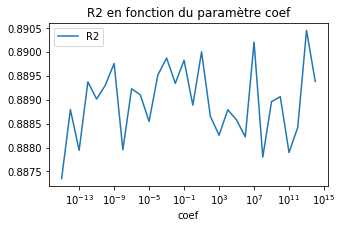

In [5]:
import pandas
df = test_model(LinearRegression())
ax = df.plot(x='coef', y="R2", logx=True, figsize=(5,3))
ax.set_title("R2 en fonction du paramètre coef");

Le modèle ne semble pas en souffrir. Les performances sont très stables. Augmentons les bornes.

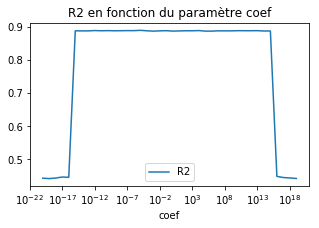

In [6]:
df = test_model(LinearRegression(), k=20)
ax = df.plot(x='coef', y="R2", logx=True, figsize=(5,3))
ax.set_title("R2 en fonction du paramètre coef");

Au delà d'un certain seuil, la performance chute. La trop grande différence d'ordre de grandeur entre les deux variables nuit à la convergence du modèle. Et si on normalise avant...

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
model = make_pipeline(StandardScaler(), LinearRegression())
model

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

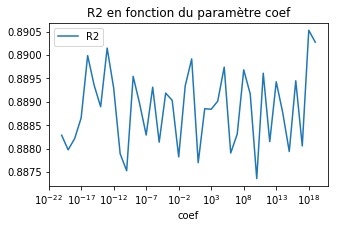

In [8]:
df = test_model(model, k=20)
ax = df.plot(x='coef', y="R2", logx=True, figsize=(5,3))
ax.set_title("R2 en fonction du paramètre coef");

Le modèle ne souffre plus de problème numérique car il travaille sur des données normalisées. Que se passe-t-il avec un arbre de décision ?

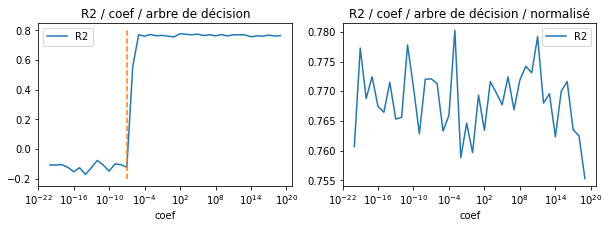

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10,3))
from sklearn.tree import DecisionTreeRegressor
df = test_model(DecisionTreeRegressor(), k=20, n=1000)
df.plot(x='coef', y="R2", logx=True, ax=ax[0])
ax[0].set_title("R2 / coef / arbre de décision")
ax[0].plot([1e-7, 1e-7], [-0.2, 0.8], '--')  # voir plus bas pour l'explication de ce seuil
model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
df = test_model(model, k=20, n=1000)
df.plot(x='coef', y="R2", logx=True, ax=ax[1])
ax[1].set_title("R2 / coef / arbre de décision / normalisé");

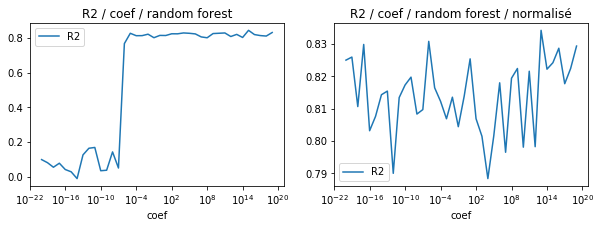

In [10]:
from sklearn.ensemble import RandomForestRegressor
fig, ax = plt.subplots(1, 2, figsize=(10,3))
df = test_model(RandomForestRegressor(n_estimators=5), k=20, n=200)
df.plot(x='coef', y="R2", logx=True, ax=ax[0])
ax[0].set_title("R2 / coef / random forest")
model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=5))
df = test_model(model, k=20, n=200)
df.plot(x='coef', y="R2", logx=True, ax=ax[1])
ax[1].set_title("R2 / coef / random forest / normalisé");

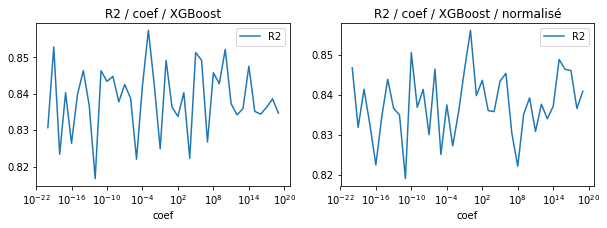

In [11]:
from xgboost import XGBRegressor
fig, ax = plt.subplots(1, 2, figsize=(10,3))
df = test_model(XGBRegressor(), k=20, n=200)
df.plot(x='coef', y="R2", logx=True, ax=ax[0])
ax[0].set_title("R2 / coef / XGBoost")
model = make_pipeline(StandardScaler(), XGBRegressor())
df = test_model(model, k=20, n=200)
df.plot(x='coef', y="R2", logx=True, ax=ax[1])
ax[1].set_title("R2 / coef / XGBoost / normalisé");

La librairie [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) est moins sensible aux problèmes d'échelle. Les arbres de décision implémentés par [scikit-learn](http://scikit-learn.org/stable/modules/tree.html) le sont de façon assez surprenante. Il faudrait regarder l'implémentation plus en détail pour comprendre pourquoi le modèle se comporte mal lorsque *coef* est proche de 0. Le code source utilise une constante [FEATURE_THRESHOLD](https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/tree/_splitter.pyx#L439) égale à $10^{-7}$ qui rend l'algorithme insensible à toute variation en deça de ce seuil.